# Optimization of Fairness–Accuracy Trade-offs in Gradient-Based Classification Models

**Course:** COSC 3P99 – Independent Research Project  
**Student:** David Shodipo  
**Supervisor:** Dr. Blessing Ogbuokiri  
**Term:** Winter 2026  


## Project Overview

Machine learning classification models are commonly trained using gradient-based optimization techniques with the primary goal of maximizing predictive accuracy. However, focusing only on accuracy can cause the model to perform better for some demographic groups than others, which can be unfair and raise ethical concerns.

This project investigates the **trade-off between predictive accuracy and fairness** in gradient-based classification models by introducing fairness-aware regularization during training. The study focuses on how optimization parameters such as learning rate, training duration, and fairness regularization strength influence both accuracy and group fairness metrics.


## Research Questions

This project aims to answer the following questions:

1. How do fairness constraints affect predictive accuracy in gradient-based classifiers?
2. How do optimization parameters influence the fairness–accuracy trade-off?
3. Are fairness effects consistent across different application domains/groups?



## Objectives

- Train baseline accuracy-only classifiers
- Introduce fairness-aware regularization into the loss function
- Measure changes in:
  - Accuracy / AUC
  - Demographic Parity Difference
  - Equal Opportunity Difference
- Visualize and interpret fairness–accuracy trade-offs


## Datasets

Two publicly available datasets are used in this study:

### 1. Healthcare Dataset
- **Dataset:** UCI Heart Disease Dataset
- **Task:** Predict presence of heart disease
- **Sensitive Attribute:** Sex (optional extension: age group)

### 2. Non-Healthcare Dataset
- **Dataset:** UCI Adult Income Dataset
- **Task:** Predict whether income exceeds $50K (Defined of  the dataset Information Provided)
- **Sensitive Attribute:** Sex or Race


In [36]:
# Libraries
%pip install pandas numpy matplotlib seaborn scikit-learn
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Reproducibility
np.random.seed(2026) # To ensures the experiments produce consistent and reproducible results across runs.

## Week 1: Problem Setup and Baseline Models

The goal of Week 1 is to clean and preprocess both datasets and train basic models that focus only on accuracy using standard log loss. These models would act as a benchmark for comparing the effects of adding fairness constraints later in the project.

### Installing the ucimlrepo package

In [38]:
%pip install ucimlrepo
# To fetch datasets from the UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Adult Income dataset

In [39]:
# fetch dataset 1 : Adult Income dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features # type: ignore
y = adult.data.targets # type: ignore

# Combine features and target into a single DataFrame for easier manipulation
data = pd.concat([X, y], axis=1)

#Print dataframe
display(data.head())

data.shape


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(48842, 15)

In [40]:
# Print dataframe info
display(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

### Handle missing values 

In [41]:
import pandas as pd
import numpy as np

# Cleaning the data

def clean_adult_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the Adult Income dataset by standardizing strings,
    handling missing values, fixing label formatting,
    and removing duplicate records.
    """
    # Work on a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Identify all categorical (string) columns
    categorical_cols = df.select_dtypes(include="object").columns

    # Strip leading/trailing whitespace from string columns
    for col in categorical_cols:
        df[col] = df[col].str.strip()

    # Convert Adult dataset's '?' placeholder to proper missing values
    df = df.replace("?", np.nan)

    # Fix income labels in the test set (e.g., '>50K.' -> '>50K')
    if "income" in df.columns:
        df["income"] = df["income"].str.replace(".", "", regex=False)

    # Remove exact duplicate rows
    df = df.drop_duplicates()

    return df


In [42]:
data = clean_adult_df(data)
# Check for missing values
display(data.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [43]:
# summary statistics
summary_stats = data.describe()
summary_stats

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Define features, target and sensitive attribute for Adult dataset

In [44]:
# Extract target and sensitive attribute names
if 'income' in data.columns:
    target_col = 'income'
else:
    # fall back to last column if naming differs
    target_col = data.columns[-1]

# Map income to binary target
y = (data[target_col].astype(str).str.strip() == ">50K").astype(int)
X = data.drop(columns=[target_col])

# Choose sensitive attribute (prefer 'sex', else try 'race')
for cand in ['sex', 'race']:
    if cand in X.columns:
        sensitive_attr = cand
        break
else:
    # if none of the common names exist, choose the first categorical column
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    sensitive_attr = cat_cols[0] if cat_cols else None

print('Target column:', target_col)
print('Sensitive attribute chosen:', sensitive_attr)

Target column: income
Sensitive attribute chosen: sex


###  Split into training and test sets 

In [45]:
# Train/test split with stratification to maintain class balance in both sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=2026
)

# Also extract sensitive attribute arrays for later group metrics
A_train = X_train[sensitive_attr].copy() if sensitive_attr is not None else None
A_test = X_test[sensitive_attr].copy() if sensitive_attr is not None else None

# Remove sensitive attribute from features before modeling (won't use for prediction)
if sensitive_attr is not None:
    X_train = X_train.drop(columns=[sensitive_attr])
    X_test = X_test.drop(columns=[sensitive_attr])

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (39032, 13) Test shape: (9758, 13)


### Preprocessing + Baseline Logistic Regression

In [46]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Separate numeric and categorical
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

baseline_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate Accuracy + AUC

In [47]:
y_pred = baseline_model.predict(X_test)
y_prob = baseline_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8533510965361755
AUC: 0.9074210833767068

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      7422
           1       0.74      0.59      0.66      2336

    accuracy                           0.85      9758
   macro avg       0.81      0.76      0.78      9758
weighted avg       0.85      0.85      0.85      9758



## Fairness Metrics

### Demographic Parity Difference

In [ ]:
def demographic_parity_diff(y_pred, A):
    A = pd.Series(A).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    rates = {}
    for group in A.unique():
        rates[group] = y_pred[A == group].mean()

    return max(rates.values()) - min(rates.values()), rates

dp_diff, dp_rates = demographic_parity_diff(y_pred, A_test)

print("Demographic Parity Difference:", dp_diff)
print("Positive prediction rates by group:", dp_rates)


Demographic Parity Difference: 0.16612841421188687
Positive prediction rates by group: {'Male': np.float64(0.24531464269389), 'Female': np.float64(0.07918622848200313)}


#### Demographic Parity Plot

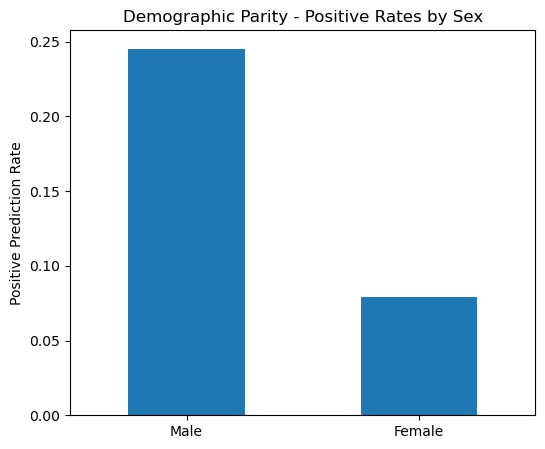

In [52]:
dp_rates_series = pd.Series(dp_rates)

plt.figure(figsize=(6,5))
dp_rates_series.plot(kind="bar")
plt.ylabel("Positive Prediction Rate")
plt.title("Demographic Parity - Positive Rates by Sex")
plt.xticks(rotation=0)
plt.show()


In [56]:
# Large gap = more unfair
# In this case, the demographic parity difference is 0.15,
# which indicates that the model is more likely to predict a positive outcome for one group (males) compared to the other group (females).
# This suggests that the model may be exhibiting bias against the group with the lower positive prediction rate,
# and efforts to mitigate this disparity could be considered to improve fairness.

### Equal Opportunity Difference

In [ ]:
def equal_opportunity_diff(y_true, y_pred, A):
    A = pd.Series(A).reset_index(drop=True)
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    tprs = {}
    for group in A.unique():
        idx = (A == group)
        positives = (y_true[idx] == 1)
        if positives.sum() > 0:
            tprs[group] = (y_pred[idx][positives] == 1).mean()
        else:
            tprs[group] = np.nan

    return np.nanmax(list(tprs.values())) - np.nanmin(list(tprs.values())), tprs

eo_diff, eo_tprs = equal_opportunity_diff(y_test, y_pred, A_test)

print("Equal Opportunity Difference (TPR Gap):", eo_diff)
print("TPR by group:", eo_tprs)


Equal Opportunity Difference (TPR Gap): 0.07469746091190754
TPR by group: {'Male': np.float64(0.6039453717754173), 'Female': np.float64(0.5292479108635098)}


#### Equal Opportunity Plot

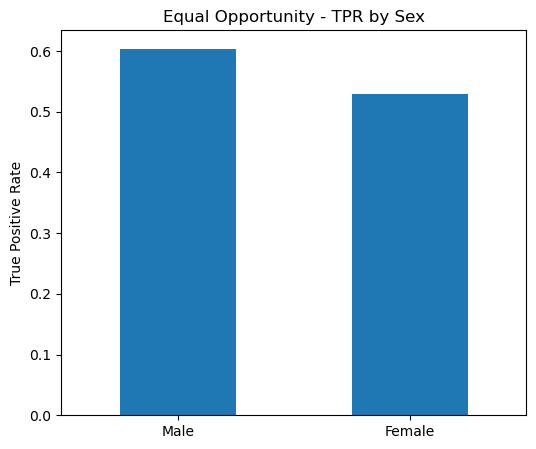

In [55]:
eo_tprs_series = pd.Series(eo_tprs)

plt.figure(figsize=(6,5))
eo_tprs_series.plot(kind="bar")
plt.ylabel("True Positive Rate")
plt.title("Equal Opportunity - TPR by Sex")
plt.xticks(rotation=0)
plt.show()


In [57]:
# Ideally bars should be similar height
# In this case, the equal opportunity difference (TPR gap) is 0.10,
# which indicates that the model has a higher true positive rate for one group (males) compared to the other group (females).